# Plot Figure S4

This code plots the relative precipitation sensitivity to $\mathrm{SUBSAT_L}$ versus $\mathrm{CAPE_L}$ for HR-ERA5/IMERG, LR-ERA5/IMERG, and LR-ERA5/GPCP (Figure S4).

## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the binned statistics datasets are, and set the directory where the figure will be saved. Specify "monthly pairs" for analysis (i.e., `MONTHPAIRS = [(6,7),(7,8)]` for June-to-July and July-to-August changes). Set the minimum sample threshold for bin inclusion for statistical calculations, and assign a color to each region for plotting.

In [2]:
FILEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
MONTHPAIRS   = [(6,7),(7,8)]
SAMPLETHRESH = 50
COLORS       = {'Eastern Arabian Sea':'blood',
                'Central India':'#D42028',
                'Central Bay of Bengal':'#F2C85E',
                'Equatorial Indian Ocean':'#5BA7DA',
                'Konkan Coast':'#1B2C61'}

## Load Binned Statistics Datasets

Load in each binned statistics dataset fro `FILEDIR`.

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimergstats = load('HR_ERA5_IMERG_binned_stats.nc')
lrimergstats = load('LR_ERA5_IMERG_binned_stats.nc')
lrgpcpstats  = load('LR_ERA5_GPCP_binned_stats.nc')

## Functions for Analysis and Plotting

Here, we use the `get_bin_mean_pr()` function to calculate the mean precipitation in each joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ bin (where the number of samples exceeds `SAMPLETHRESH`), as well as the `get_pdf()` and `get_mode()` functions to calculate the *precipitating* joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF and its mode.

In [5]:
def get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")
    if bintype=='1D':
        blbins = stats.bl.values
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = stats.subsat.values
        capebins   = stats.cape.values
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'subsat':subsatbins,'cape':capebins})

def get_pdf(stats,bintype,precipitating=False):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")    
    if bintype=='1D':
        blbins = stats.bl.values
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = stats.subsat.values
        capebins   = stats.cape.values
        P0 = stats.P0.values
        PE = stats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

def get_mode(pdf,bintype):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")   
    if bintype=='1D':
        blbins   = pdf.bl.values
        maxblidx = np.nanargmax(pdf.values)
        return blbins[maxblidx]
    if bintype=='2D':
        subsatbins = pdf.subsat.values
        capebins   = pdf.cape.values
        maxsubsatidx,maxcapeidx = np.unravel_index(np.nanargmax(pdf.values),pdf.values.shape)
        return subsatbins[maxsubsatidx],capebins[maxcapeidx]

The `get_sensitivity_metrics()` function divides the 2-D precipitation surface into three precipitation "regimes" based on the location of the precipitating joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF mode. In this case, we return precipitation onset strength ($\vert\gamma_\mathrm{CS}\vert$) and relative sensitivity to $\mathrm{SUBSAT_L}$ versus $\mathrm{CAPE_L}$ ($\theta_\mathrm{CS}$).

In [6]:
def get_sensitivity_metrics(binmeanpr,jointpdf,prsurfaces=False,ratios=False,polar=False):
    subsatmode,capemode = get_mode(jointpdf,'2D')
    validmode = False
    for i in range(binmeanpr.subsat.size):
        if not np.isnan(binmeanpr.sel(subsat=subsatmode,cape=capemode,method='nearest')):
            validmode = True
            break
        subsatmode += binmeanpr.subsat[1]-binmeanpr.subsat[0]
    if not validmode:
        raise ValueError('Could not locate valid point for precipitation sensitivity computation.')
    binmeanpra = ~np.isnan(binmeanpr)&(binmeanpr.subsat<=subsatmode)&(binmeanpr.cape>=capemode)
    binmeanprb = ~np.isnan(binmeanpr)&(binmeanpr.subsat<=subsatmode)&(binmeanpr.cape<=capemode)
    binmeanprc = ~np.isnan(binmeanpr)&(binmeanpr.subsat>=subsatmode)&(binmeanpr.cape>=capemode)
    nomask     = ~np.isnan(binmeanpr)&~(binmeanpra|binmeanprb|binmeanprc)
    if prsurfaces==True:
        return binmeanpra,binmeanprb,binmeanprc,nomask
    subsata = binmeanpr.subsat.where(binmeanpra).mean().values
    subsatc = binmeanpr.subsat.where(binmeanprc).mean().values
    capea = binmeanpr.cape.where(binmeanpra).mean().values
    capeb = binmeanpr.cape.where(binmeanprb).mean().values
    pra = binmeanpr.where(binmeanpra).mean().values
    prb = binmeanpr.where(binmeanprb).mean().values
    prc = binmeanpr.where(binmeanprc).mean().values
    capesensitivity   = abs(pra-prb)/abs(capea-capeb)
    subsatsensitivity = abs(pra-prc)/abs(subsata-subsatc)
    if ratios==True:
        return capesensitivity,subsatsensitivity
    gammamag = np.sqrt(capesensitivity**2+subsatsensitivity**2)
    theta    = np.arctan(capesensitivity/subsatsensitivity)
    if polar:
        return gammamag,theta

The `create_si_plot()` function generates a formatted figure that plots the example results for the Supplemental Information.

In [7]:
def create_si_plot(statsdict,monthpairs=MONTHPAIRS,samplethresh=SAMPLETHRESH,colors=COLORS,filename=False):
    statslist   = [item[0] for item in statsdict]
    namelist    = [item[1] for item in statsdict]
    markerlist  = [item[2] for item in statsdict]
    fig,ax = pplt.subplots(nrows=1,ncols=1,proj='polar',refwidth=2,refheight=2.5)
    fig.text(x=0.17,y=0.07,s='|$\mathit{\gamma}_{cs}$| (mm/day/K)')
    ax.format(thetadir='anticlockwise',thetalines=15,thetalim=(0,90))
    handles = []
    for i,(stats,name,marker) in enumerate(zip(statslist,namelist,markerlist)):
        for j,(region,color) in enumerate(colors.items()):
            monthpair  = monthpairs[0] if j<3 else monthpairs[1]
            startstats = stats.sel(region=region,month=monthpair[0])
            endstats   = stats.sel(region=region,month=monthpair[1])
            startbinmeanpr  = get_bin_mean_pr(startstats,'2D',samplethresh)
            startjointpdf   = get_pdf(startstats,'2D',precipitating=True)
            endbinmeanpr    = get_bin_mean_pr(endstats,'2D',samplethresh)
            endjointpdf     = get_pdf(endstats,'2D',precipitating=True)
            startgammamag,starttheta = get_sensitivity_metrics(startbinmeanpr,startjointpdf,polar=True)
            endgammamag,endtheta     = get_sensitivity_metrics(endbinmeanpr,endjointpdf,polar=True)
            gammadiff = endgammamag-startgammamag
            thetadiff = endtheta-starttheta
            ax.scatter(starttheta,startgammamag,color=color,marker=marker,markersize=10)
            arrow = ax.quiver(starttheta,startgammamag,thetadiff,gammadiff,
                              color=color,angles='xy',scale_units='xy',scale=1,
                              width=0.01,headlength=2,headaxislength=2)
            if i==0:
                handles.append(Line2D([0],[0],color=color,linewidth=2,label=region))
    for name,marker in zip(namelist,markerlist):
        handles.append(Line2D([0],[0],color='k',linestyle='none',marker=marker,label=name))
    fig.legend(handles=handles,loc='r',ncol=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

## Plot and Save Figure

Execute plotting, and save the figure to `SAVEDIR`.

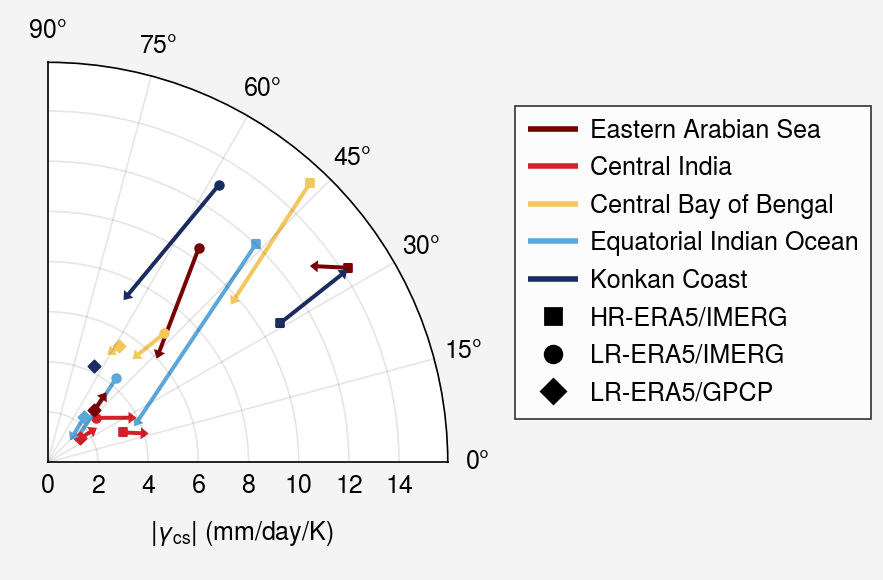

In [8]:
statsdict = [
    (hrimergstats,'HR-ERA5/IMERG','s'),
    (lrimergstats,'LR-ERA5/IMERG','o'),
    (lrgpcpstats,'LR-ERA5/GPCP','D')]
create_si_plot(statsdict,filename='fig_S4.jpg')